# Project 1: Query Project
## Part 3
*W205 | Section 5 | Lina Yang*
___
This markdown contains the following deliverables for Project 1: 

- [Part 3 - Employ notebooks to synthesis query project results](#Part-3)

To review earlier parts of this project, follow the links below: 

- [Part 1 - Querying Data with BigQuery](https://github.com/mids-w205-de-sola/project-1-linayang-mids/blob/assignment_1/Project_1_Part_1_2.md#Part-1)
- [Part 2 - Querying data from the BigQuery CLI](https://github.com/mids-w205-de-sola/project-1-linayang-mids/blob/assignment_1/Project_1_Part_1_2.md#Part-2)
___

<a id='Part-3'></a>
### Part 3 - Employ notebooks to synthesize query project results

In this section we will answer the following questions: 
- [What are the 5 most popular trips that you would call "commuter trips"?](#commuter)
- [What are your recommendations for offers (justify based on your findings)?](#recommendation)

#### Import libraries 

We will import python libraries needed for data transformation and visualization.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

from datetime import datetime

<a id='commuter'></a>
#### What are the 5 most popular trips that you would call "commuter trips?" 

First let's define a commuter. A commuter is "a person who travels some distance to work on a regular basis." After exploring the data in Part 1 and Part 2, I have decided to define commuter trips as trips that were taken by Subscribers Monday through Friday between 6 to 10 am and 15 to 19 pm. We can see in the below charts, Subscriber trips peak at two times each day which is aligns with standard US rush hour periods. Additionally, Customers don't seem to fit this modus operandi as the time of day for when folks typically head to work doesn't affect the volume/frequency of bike trips. Subscribers are also less likely to rent bikes on Saturday and Sunday, which are typical days off for work.

Based on the aforementioned criteria, the top five commuter trips are as follows: 
- San Francisco Caltrain 2 (330 Townsend) -> Townsend at 7th
- 2nd at Townsend -> Harry Bridges Plaza (Ferry Building)
- Embarcadero at Folsom -> San Francisco Caltrain (Townsend at 4th)
- Harry Bridges Plaza (Ferry Building) -> 2nd at Townsend
- Temporary Transbay Terminal (Howard at Beale) -> San Francisco Caltrain (Townsend at 4th)

In [13]:
%%bigquery hour_df

SELECT
  *
FROM (
  SELECT
    subscriber_type,
    EXTRACT(hour
    FROM
      CAST(start_date AS time)) AS hour,
    COUNT(*) AS num_trips
  FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
  GROUP BY
    subscriber_type,
    hour ) PIVOT ( SUM(num_trips) AS total_trips FOR subscriber_type IN ('Customer',
      'Subscriber') )
ORDER BY
  hour 

Downloading: 100%|██████████| 24/24 [00:01<00:00, 15.98rows/s]


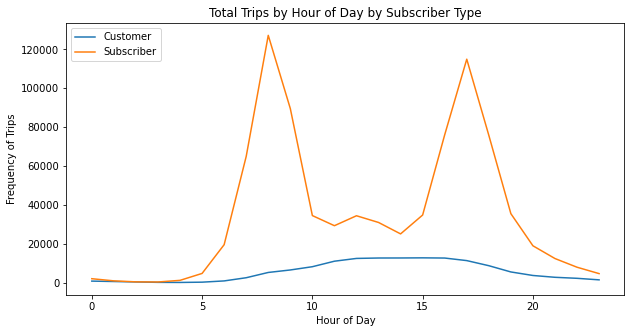

In [23]:
subscriber_type = ['Customer', 'Subscriber']

hour_df.set_index('hour').plot(figsize=(10,5))
plt.xlabel('Hour of Day')
plt.ylabel('Frequency of Trips')
plt.title('Total Trips by Hour of Day by Subscriber Type')
plt.legend(subscriber_type, loc=2)

In [25]:
%%bigquery day_df
SELECT
  *
FROM (
  SELECT
    subscriber_type,
    EXTRACT(DAYOFWEEK
    FROM
      CAST(start_date AS DATE)) AS day_of_week,
    COUNT(*) AS num_trips
  FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
  GROUP BY
    subscriber_type,
    day_of_week ) PIVOT ( SUM(num_trips) AS total_trips FOR subscriber_type IN ('Customer',
      'Subscriber') )
ORDER BY
  DAY_OF_WEEK

Downloading: 100%|██████████| 7/7 [00:01<00:00,  5.31rows/s]


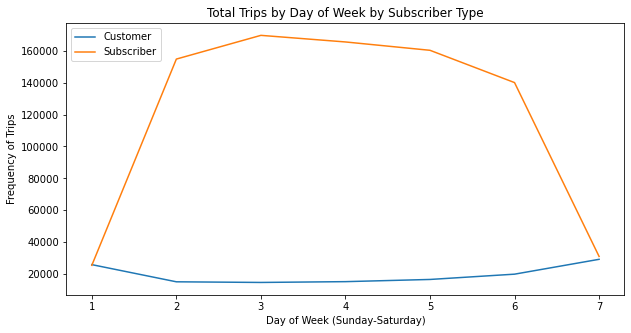

In [29]:
subscriber_type = ['Customer', 'Subscriber']

day_df.set_index('day_of_week').plot(figsize=(10,5))
plt.xlabel('Day of Week (Sunday-Saturday)')
plt.ylabel('Frequency of Trips')
plt.title('Total Trips by Day of Week by Subscriber Type')
plt.legend(subscriber_type, loc=2)

The top five commuter trips are as follows: 
- San Francisco Caltrain 2 (330 Townsend) -> Townsend at 7th
- 2nd at Townsend -> Harry Bridges Plaza (Ferry Building)
- Embarcadero at Folsom -> San Francisco Caltrain (Townsend at 4th)
- Harry Bridges Plaza (Ferry Building) -> 2nd at Townsend
- Temporary Transbay Terminal (Howard at Beale) -> San Francisco Caltrain (Townsend at 4th)

In [2]:
%%bigquery top_5_commuter_trips

SELECT
  start_station_name,
  end_station_name,
  COUNT(trip_id) AS num_trips
FROM
  `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
  subscriber_type = 'Subscriber'
  AND EXTRACT(hour
  FROM
    CAST(start_date AS time)) IN (6,
    7,
    8,
    9,
    10,
    15,
    16,
    17,
    18,
    19)
  AND EXTRACT(DAYOFWEEK
  FROM
    CAST(start_date AS DATE)) IN (2,
    3,
    4,
    5,
    6)
GROUP BY
  start_station_name,
  end_station_name
ORDER BY
  num_trips DESC
LIMIT
  5

Downloading: 100%|██████████| 5/5 [00:02<00:00,  2.09rows/s]


In [3]:
top_5_commuter_trips

,start_station_name,end_station_name,num_trips
0,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,6519
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5971
2,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),5587
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5511
4,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),5372


<a id='recommendation'></a>
#### What are my recommendations for offers? 

With any promotional/offer analysis, we need to better understand how it affects our revenue. While we do not have access to Subscriber/Customer level data to estimate retention or membership fees, we do have the ability to estimate the exceeded time limit fee a trip generates. Bay Wheels offers bike riders a time limit for each ride, and if exceeded we charge them a nominal fee for additional minutes incurred. For Subscribers we give riders 45-minute rides and then charge an additional \\$0.20 per minute and for Customers we give riders 30-minute rides and then charge an additional \\$0.30 per minute.

We see later in the analysis that while the fee is nominal, with almost one million trips taken during 2013-2016, the money generated from this offering is actually quite significant. We also see year over year, this fee is reducing which provides Bay Wheels an opportunity right now to test pricing to see if this provides more revenue in the future. Customers are more likely to exceed their time limit per ride and historically has generated more money through these fees for Bay Wheels. This may connote that Customers are more likely to be enjoying their bike ride, taking longer rides, and maybe even less price-sensitive. We also see that when we measure the average revenue over hours of the day, riders are generating higher exceeded time limit fees for Bay Wheels during the late evening which typically is synonymous with night life and leisure actiivities. It may connote that bikers are less price-sensitive during these times and are less focused on their bike's time limit. As they say, time flies when you are having fun.   

I recommend increasing the exceeded time limit fee to \\$0.30 for Subscribers and \\$0.35 for Customers and test this to see if it changes the demand or behavior of riders. Additionally, dynamically increasing the exceeded time limit fee in the late evening for both Subscribers and Customers would also help generate some additional revenue as this behavior seems to be more frequent during these hours. Also, in turn by increasing the exceeded time limit fee during these hours, it might help with having bikes returned on time allowing our team to be more productive with maintaining stations or bikes during these typical service hours.

Without further ado, let's start with seeing where the business stands as of 2016. As we can see in the below graph we have been seeing Subscriber growth month over month.The frequency of trips does drop significantly during major holidays like Christmas, but overall the mean average growth month over month from 2013 to 2016 for Subscribers is 47%.

In [4]:
%%bigquery mom_growth

WITH
  base_table AS (
  SELECT
    *
  FROM (
    SELECT
      DATE_TRUNC(CAST(start_date AS DATE), month) AS month_start,
      subscriber_type,
      COUNT(*) AS num_trips
    FROM
      `bigquery-public-data.san_francisco.bikeshare_trips`
    GROUP BY
      1,
      2
    ORDER BY
      1,
      2 ) PIVOT ( SUM(num_trips) AS total_trips FOR subscriber_type IN ('Customer',
        'Subscriber') )
  ORDER BY
    month_start )
SELECT
  month_start,
  total_trips_Customer,
  (total_trips_Customer - LAG(total_trips_Customer, 1) OVER (ORDER BY month_start)) / LAG(total_trips_Customer, 1) OVER (ORDER BY month_start) AS customer_growth,
  total_trips_Subscriber,
  (total_trips_Subscriber - LAG(total_trips_Subscriber, 1) OVER (ORDER BY month_start)) / LAG(total_trips_Subscriber, 1) OVER (ORDER BY month_start) AS subscriber_growth
FROM
  base_table
ORDER BY
  month_start

Downloading: 100%|██████████| 37/37 [00:01<00:00, 26.99rows/s]


[Text(0, 0.5, 'Customer Growth')]

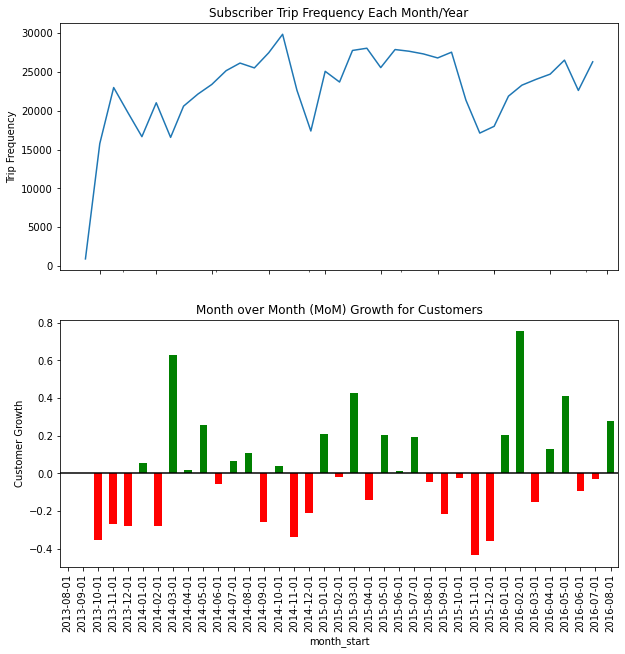

In [5]:
# level set initial growth 
mom_growth.loc[0:1,'customer_growth'] = 0
mom_growth.loc[0:1,'subscriber_growth'] = 0

# create two vertically arranged plots
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212) 

# plot subscriber trips line chart
ax = mom_growth.plot(x="month_start", y="total_trips_Subscriber", ax=ax1, sharex='month_start', legend=False, title='Subscriber Trip Frequency Each Month/Year')
ax.set(ylabel='Trip Frequency')

# plot customer bar chart
ax = mom_growth.plot(x="month_start", y="customer_growth", ax=ax2, sharex='month_start', kind='bar', legend=False, color=(mom_growth['customer_growth']>0).map({True:'g', False:'r'}), title="Month over Month (MoM) Growth for Customers") 
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.xticks(rotation=90)
ax.set(ylabel='Customer Growth')

As mentioned above, Bay Wheels offers bike riders a time limit for each ride, and if exceeded we charge them a nominal fee for additional minutes incurred. For Subscribers, we give riders 45-minute rides and then charge an additional \\$0.20 per minute, and for Customers, we give riders 30-minute rides and then charge an additional \\$0.30 per minute. We can see below that 30% of all trips taken by Customers exceeded their initial 30 mins, while less than 1% of Subscribers exceed their initial 45 mins. This indicates that Subscribers are taking shorter rides than Customers or perhaps more honed into their end destination and perhaps even more price sensitive.

In [6]:
%%bigquery exceed_df
WITH
  base_table AS (
  SELECT
    trip_id,
    subscriber_type,
    start_station_name,
    end_station_name,
    duration_sec,
    CASE
      WHEN subscriber_type= 'Subscriber' AND duration_sec > 2700 THEN 'exceeded'
      WHEN subscriber_type='Customer'
    AND duration_sec >1800 THEN 'exceeded'
    ELSE
    'under'
  END
    AS exceeded_min_flag
  FROM
    `bigquery-public-data.san_francisco.bikeshare_trips` )
SELECT
  *
FROM (
  SELECT
    subscriber_type,
    exceeded_min_flag,
    COUNT(trip_id) total_trips
  FROM
    base_table
  GROUP BY
    1,
    2 ) PIVOT (SUM(total_trips) AS total_trips FOR subscriber_type IN ('Customer',
      'Subscriber'))

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.22rows/s]


array([<AxesSubplot:ylabel='total_trips_Customer'>,
       <AxesSubplot:ylabel='total_trips_Subscriber'>], dtype=object)

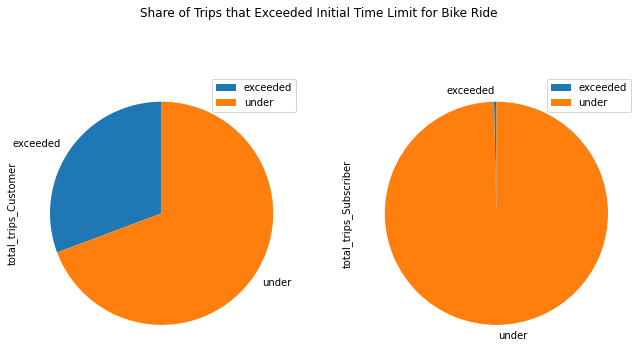

In [8]:
# reset index
pie_df = exceed_df.set_index('exceeded_min_flag')

# create a pie chart
pie_df.plot.pie(subplots=True, figsize=(11, 6), title = 'Share of Trips that Exceeded Initial Time Limit for Bike Ride', startangle=90)

Additionally, because Subscribers rarely exceed their initial time limit per ride, the incremental revenue Bay Wheels generates from these nominal fees is much smaller than Customers. While the nominal fee is less than a dollar, it can be quite substantial in yearly revenue as indicated in the below chart.

In [9]:
%%bigquery exceed_year_df
SELECT
  *
FROM (
  SELECT
    EXTRACT(YEAR
    FROM
      start_date) AS year,
    subscriber_type,
    ROUND(SUM(exceeded_min_rev),2) total_exceeded_min_rev
  FROM (
    SELECT
      trip_id,
      subscriber_type,
      start_date,
      start_station_name,
      end_station_name,
      duration_sec,
      CASE
        WHEN subscriber_type= 'Subscriber' AND duration_sec > 2700 THEN (duration_sec-2700)/60*0.30
        WHEN subscriber_type='Customer'
      AND duration_sec >1800 THEN (duration_sec-1800)/60*0.20
      ELSE
      NULL
    END
      AS exceeded_min_rev
    FROM
      `bigquery-public-data.san_francisco.bikeshare_trips` )
  GROUP BY
    1,
    2 ) PIVOT (SUM(total_exceeded_min_rev) AS total_exceeded_min_rev FOR subscriber_type IN ('Customer',
      'Subscriber'))
ORDER BY
  1

Downloading: 100%|██████████| 4/4 [00:03<00:00,  1.33rows/s]


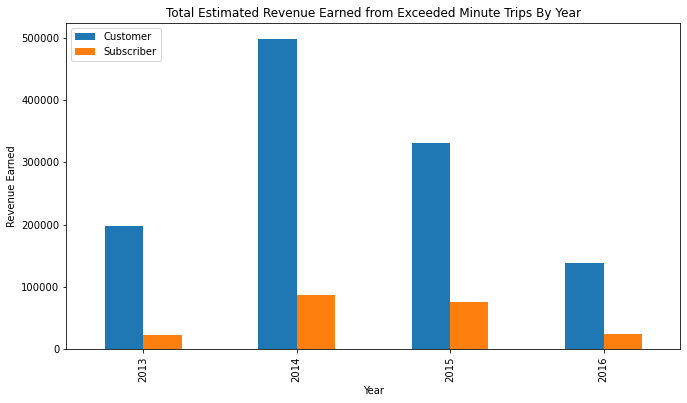

In [10]:
subscriber_type = ['Customer', 'Subscriber']

exceed_year_df.plot(x='year', y=['total_exceeded_min_rev_Customer','total_exceeded_min_rev_Subscriber'], kind='bar',figsize=(11, 6))
plt.title('Total Estimated Revenue Earned from Exceeded Minute Trips By Year')
plt.xlabel('Year')
plt.ylabel('Revenue Earned')
plt.legend(subscriber_type, loc=2)

But when do these nominal fees incur the most? Interestingly, we discovered that Subscribers had a huge spike in average exceeded fees at 6am, while for both Subscribers and Customers we see the fees having a heavy tail later in the evening with generating exceeded fees in the below chart.

In [11]:
%%bigquery avg_exceed_hour_df
SELECT
  *
FROM (
  SELECT
    EXTRACT(HOUR
    FROM
      start_date) AS hour,
    subscriber_type,
    ROUND(AVG(exceeded_min_rev),2) avg_exceeded_min_rev
  FROM (
    SELECT
      trip_id,
      subscriber_type,
      start_date,
      start_station_name,
      end_station_name,
      duration_sec,
      CASE
        WHEN subscriber_type= 'Subscriber' AND duration_sec > 2700 THEN (duration_sec-2700)/60*0.30
        WHEN subscriber_type='Customer'
      AND duration_sec >1800 THEN (duration_sec-1800)/60*0.20
      ELSE
      NULL
    END
      AS exceeded_min_rev
    FROM
      `bigquery-public-data.san_francisco.bikeshare_trips` )
  GROUP BY
    1,
    2 ) PIVOT (SUM(avg_exceeded_min_rev) AS avg_exceeded_min_rev FOR subscriber_type IN ('Customer',
      'Subscriber'))
ORDER BY
  1

Downloading: 100%|██████████| 24/24 [00:02<00:00,  8.62rows/s]


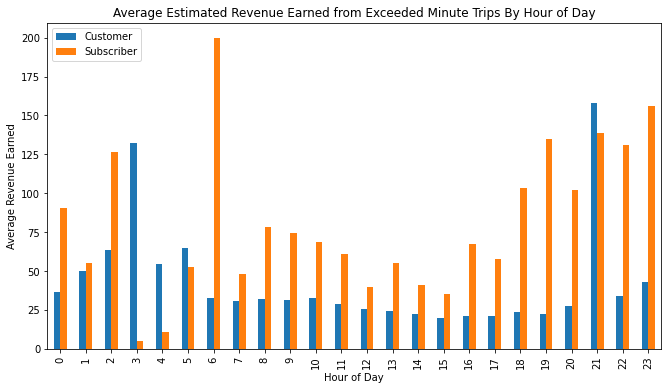

In [12]:
avg_exceed_hour_df.plot(x='hour', y=['avg_exceeded_min_rev_Customer','avg_exceeded_min_rev_Subscriber'], kind='bar',figsize=(11, 6))
plt.title('Average Estimated Revenue Earned from Exceeded Minute Trips By Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Revenue Earned')
plt.legend(subscriber_type, loc=2)

#### Conclusion
So, while Subscribers are seeing month-over-month growth, there is possibly a missed opportunity with keeping this exceeded time limit fee offer at \\$0.20 for Subscribers and keeping it a fixed rate across all hours of the day for both Subscribers and Customers. I recommend increasing the exceeded time limit fee to \\$0.30 for Subscribers and \\$0.35 for Customers and test this to see if it changes the demand or behavior of riders. Additionally, dynamically increasing the exceeded time limit fee in the late evening for both Subscribers and Customers would also help generate some additional revenue as this behavior seems to be more frequent during these hours. Also, in turn by increasing the exceeded time limit fee during these hours might help with having bikes returned on time allowing our team to be more productive with maintaining stations or bikes during these hours.